In [14]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [3]:
# Muat Dataset
# Pastikan nama file dan delimiter sesuai dengan file yang Anda unggah
df = pd.read_csv('Life_Expectancy_Data.csv', delimiter=';')

# Tampilkan 5 baris pertama data
print("5 Baris Pertama Data:")
print(df.head())

# Tampilkan informasi dasar data (tipe data, non-null counts)
print("\nInformasi Data:")
df.info()

5 Baris Pertama Data:
       Country  Year      Status  Life expectancy   Adult Mortality  \
0  Afghanistan  2015  Developing              65.0            263.0   
1  Afghanistan  2014  Developing              59.9            271.0   
2  Afghanistan  2013  Developing              59.9            268.0   
3  Afghanistan  2012  Developing              59.5            272.0   
4  Afghanistan  2011  Developing              59.2            275.0   

   infant deaths  Alcohol percentage expenditure  Hepatitis B  Measles   ...  \
0             62     0.01          7.127.962.362         65.0      1154  ...   
1             64     0.01          7.352.358.168         62.0       492  ...   
2             66     0.01          7.321.924.272         64.0       430  ...   
3             69     0.01            781.842.153         67.0      2787  ...   
4             71     0.01          7.097.108.703         68.0      3013  ...   

   Polio  Total expenditure  Diphtheria    HIV/AIDS          GDP  Popu

In [5]:
# --- BAGIAN 2: BERSIH-BERSIH AWAL ---
print("\n--- Memulai Pembersihan ---")
print(f"Jumlah data awal: {df.shape[0]} baris.")

# 1. Bersihkan spasi di nama kolom (Biar tidak error saat dipanggil)
df.columns = [col.strip() for col in df.columns]

# 2. Hapus Negara Kecil (Sesuai Tugas)
negara_dibuang = [
    'Vanuatu', 'Tonga', 'Togo', 'Cabo Verde', 'Tuvalu', 'Niue', 
    'Monaco', 'Nauru', 'San Marino', 'Cook Islands', 
    'Federated States of Micronesia', 'Saint Kitts and Nevis', 
    'Marshall Islands', 'Palau', 'Dominica', 
    'Saint Vincent and the Grenadines', 'Kiribati', 'Holy See'
]
# Simbol '~' artinya "KECUALI negara yang ada di daftar"
df = df[~df['Country'].isin(negara_dibuang)].copy()
print(f"Sisa data setelah hapus negara kecil: {df.shape[0]} baris.")



--- Memulai Pembersihan ---
Jumlah data awal: 2938 baris.
Sisa data setelah hapus negara kecil: 2832 baris.


In [6]:
# Hapus baris jika kolom 'Life expectancy' kosong
df_bersih = df.dropna(subset=['Life expectancy']).copy()
print(f"Sisa data setelah hapus Target kosong: {df_bersih.shape[0]} baris.")


Sisa data setelah hapus Target kosong: 2832 baris.


In [ ]:
# Kolom lain yang bolong (seperti GDP) kita isi dengan nilai tengah (Median)
# Kita isi berdasarkan kelompok 'Status' (Negara Maju/Berkembang) biar akurat.

daftar_kolom_diisi = ['Population', 'Hepatitis B', 'GDP', 'Total expenditure', 
                      'Alcohol', 'BMI', 'Schooling', 'Income composition of resources']

# Pastikan kolom GDP bertipe numerik (hilangkan titik ribuan dan ubah ke float)
if 'GDP' in df_bersih.columns:
    df_bersih['GDP'] = (
        df_bersih['GDP']
        .replace(r'\.', '', regex=True)
        .replace('', np.nan)
        .astype(float)
    )

for kolom in daftar_kolom_diisi:
    if kolom in df_bersih.columns:
        # Isi yang kosong dengan Median kelompoknya
        df_bersih[kolom] = df_bersih.groupby('Status')[kolom].transform(lambda x: x.fillna(x.median()))

print("✅ Imputasi data kosong selesai.")

# Tentukan path_induk sebagai direktori kerja saat ini
path_induk = os.getcwd()

nama_file_baru = 'data_siap_pakai.csv'
lokasi_simpan  = os.path.normpath(os.path.join(path_induk, '..', 'data', nama_file_baru))

✅ Imputasi data kosong selesai.


In [23]:
# 1. Statistik Deskriptif
print("\n--- Statistik Deskriptif Data Bersih ---")
# Gunakan df_bersih dan nama kolom yang benar (mengandung spasi)
print(df_bersih[['Life expectancy', 'GDP', 'Schooling', 'Adult Mortality']].describe().T)



--- Statistik Deskriptif Data Bersih ---
                  count          mean           std      min          25%  \
Life expectancy  2832.0  6.924541e+01  9.614267e+00     36.3         63.0   
GDP              2832.0  1.500787e+09  2.209358e+09  11456.0  149844147.5   
Schooling        2832.0  1.204929e+01  3.334570e+00      0.0         10.2   
Adult Mortality  2832.0  1.648658e+02  1.252409e+02      1.0         73.0   

                         50%           75%           max  
Life expectancy         72.2  7.580000e+01  8.900000e+01  
GDP              469789732.0  1.734929e+09  9.988227e+09  
Schooling               12.3  1.430000e+01  2.070000e+01  
Adult Mortality        143.0  2.290000e+02  7.230000e+02  


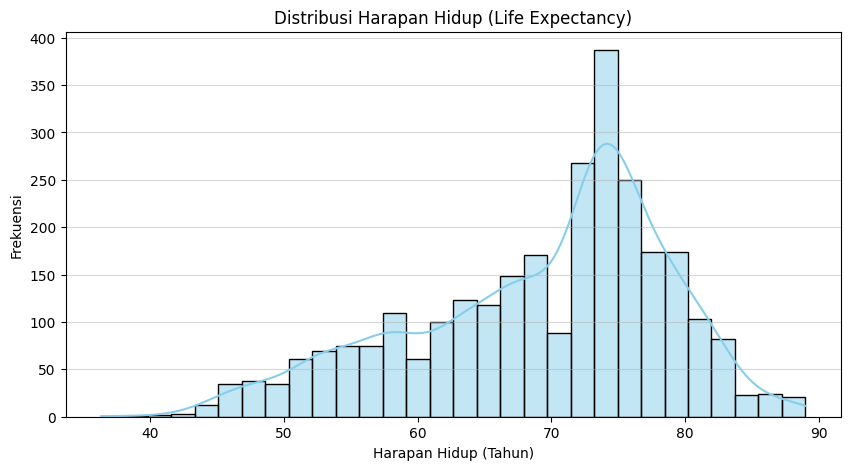

Rata-rata Harapan Hidup: 69.25 tahun
Median Harapan Hidup: 72.2 tahun


In [16]:
# 2. Distribusi Variabel Target
plt.figure(figsize=(10, 5))
sns.histplot(df_bersih['Life expectancy'], kde=True, bins=30, color='skyblue')
plt.title('Distribusi Harapan Hidup (Life Expectancy)')
plt.xlabel('Harapan Hidup (Tahun)')
plt.ylabel('Frekuensi')
plt.grid(axis='y', alpha=0.5)
plt.show()

print(f"Rata-rata Harapan Hidup: {df_bersih['Life expectancy'].mean():.2f} tahun")
print(f"Median Harapan Hidup: {df_bersih['Life expectancy'].median()} tahun")

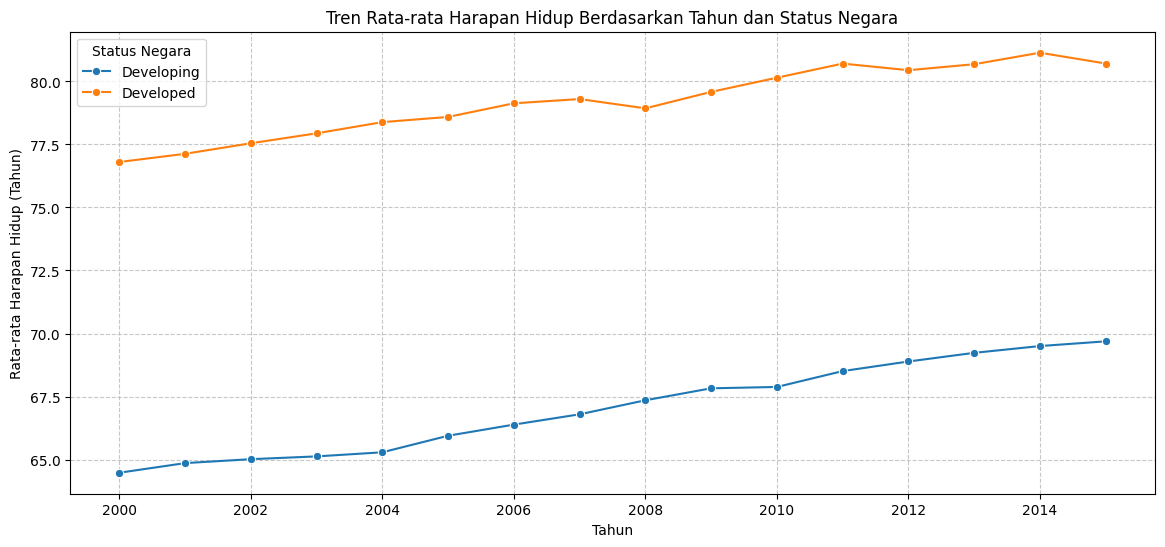

In [17]:
# 3. Tren Harapan Hidup Berdasarkan Tahun dan Status
plt.figure(figsize=(14, 6))
# Gunakan kolom 'Status' untuk membagi tren
sns.lineplot(data=df_bersih, x='Year', y='Life expectancy', hue='Status', errorbar=None, marker='o')

plt.title('Tren Rata-rata Harapan Hidup Berdasarkan Tahun dan Status Negara')
plt.xlabel('Tahun')
plt.ylabel('Rata-rata Harapan Hidup (Tahun)')
plt.legend(title='Status Negara')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

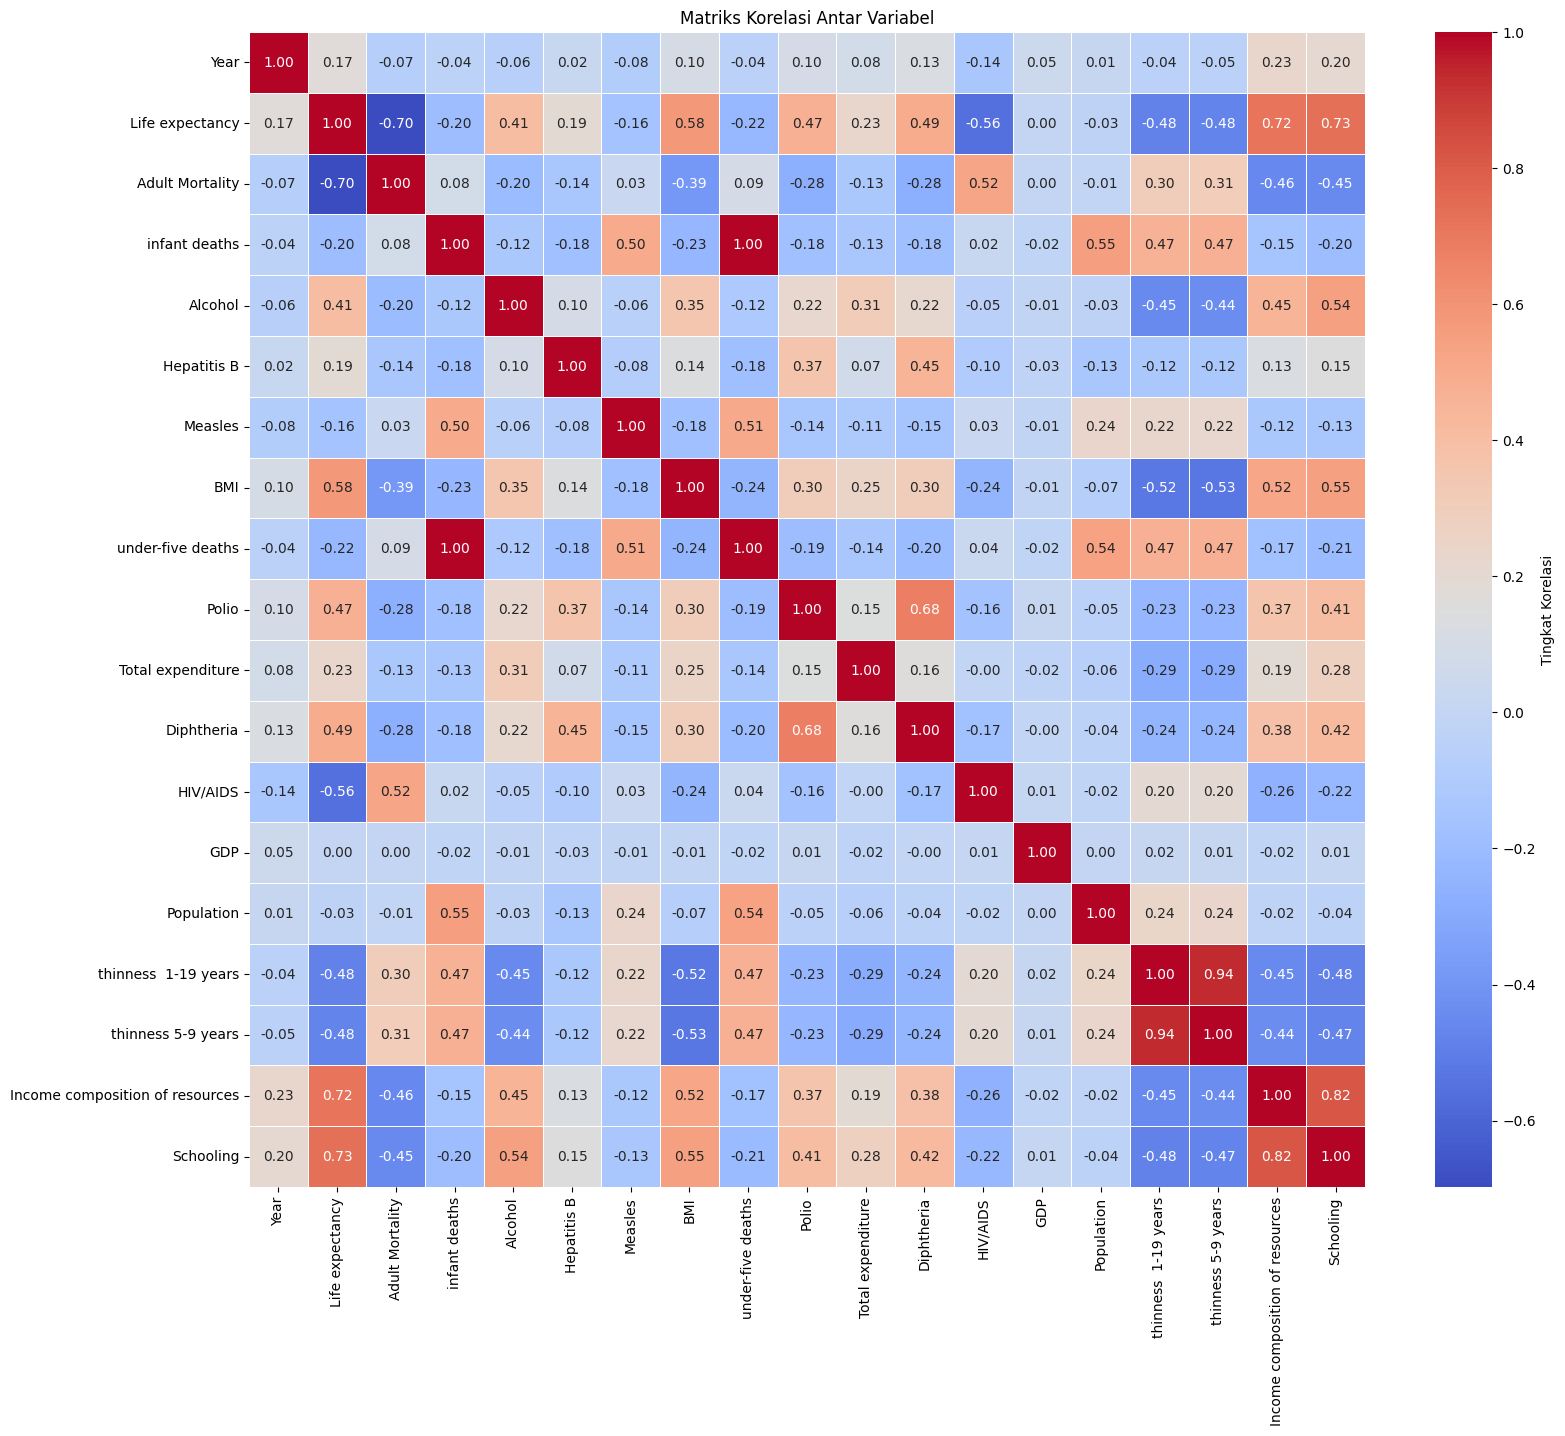


--- Fitur dengan Korelasi Terkuat terhadap Life expectancy ---
Schooling    0.734103
Name: Life expectancy, dtype: float64
Adult Mortality   -0.697668
Name: Life expectancy, dtype: float64


In [25]:
# 4. Heatmap Korelasi
# Hitung matriks korelasi
correlation_matrix = df_bersih.corr(numeric_only=True)

# Visualisasi Korelasi dengan Heatmap
plt.figure(figsize=(18, 15))
sns.heatmap(
    correlation_matrix, 
    annot=True, 
    cmap='coolwarm', 
    fmt=".2f", 
    linewidths=.5,
    cbar_kws={'label': 'Tingkat Korelasi'}
)
plt.title('Matriks Korelasi Antar Variabel')
plt.show()

# Tampilkan 5 Fitur dengan Korelasi Terkuat terhadap Life expectancy
print("\n--- Fitur dengan Korelasi Terkuat terhadap Life expectancy ---")
# Urutkan korelasi absolut, abaikan korelasi dengan dirinya sendiri
korelasi_target = correlation_matrix['Life expectancy'].sort_values(ascending=False).drop('Life expectancy')
print(korelasi_target.head(1))
print(korelasi_target.tail(1))

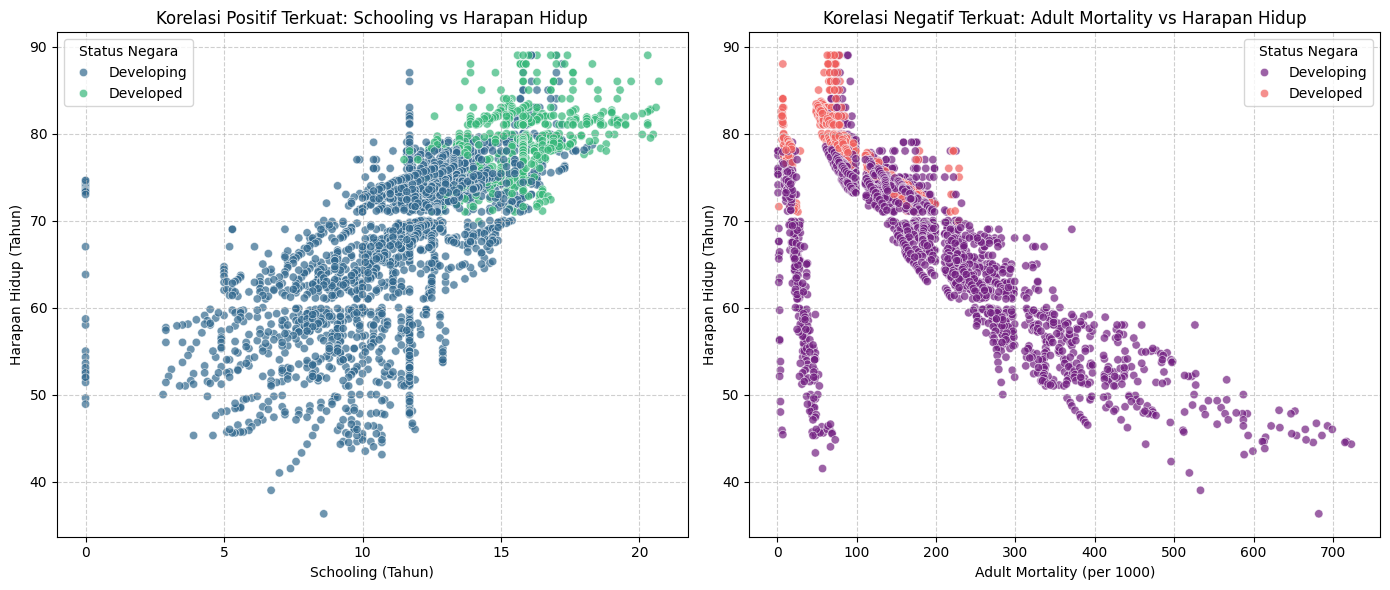

In [45]:
# Hasil Korelasi:
# Fitur Positif Terkuat: Schooling (0.7341)
# Fitur Negatif Terkuat: Adult Mortality (-0.6977)

# Visualisasi Scatter Plot
plt.figure(figsize=(14, 6))

# Plot 1: Korelasi Positif Terkuat
plt.subplot(1, 2, 1)
sns.scatterplot(
    data=df_bersih, 
    x='Schooling', # Fitur Positif Terkuat
    y='Life expectancy', 
    hue='Status',
    palette='viridis',
    alpha=0.7
)
plt.title(f'Korelasi Positif Terkuat: Schooling vs Harapan Hidup')
plt.xlabel('Schooling (Tahun)')
plt.ylabel('Harapan Hidup (Tahun)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Status Negara')

# Plot 2: Korelasi Negatif Terkuat
plt.subplot(1, 2, 2)
sns.scatterplot(
    data=df_bersih, 
    x='Adult Mortality', # Fitur Negatif Terkuat
    y='Life expectancy', 
    hue='Status',
    palette='magma',
    alpha=0.7
)
plt.title(f'Korelasi Negatif Terkuat: Adult Mortality vs Harapan Hidup')
plt.xlabel('Adult Mortality (per 1000)')
plt.ylabel('Harapan Hidup (Tahun)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Status Negara')

plt.tight_layout()
plt.show() # Gambar sudah tersimpan sebagai 'scatter_correlation_plot.png'

In [26]:
# 2. Sebaran Status Negara (Human View)
print("\n## 2. SEBARAN STATUS NEGARA (DEVELOPED vs DEVELOPING)")
print("-----------------------------------------------------")
status_counts = df['Status'].value_counts()
# Menggunakan to_string() untuk output Series yang lebih rapi
print(status_counts.to_string(header=True, name="Status Count"))
print("-----------------------------------------------------")


## 2. SEBARAN STATUS NEGARA (DEVELOPED vs DEVELOPING)
-----------------------------------------------------
Status
Developing    2320
Developed      512
Name: count
-----------------------------------------------------


C:\Users\ASUS\AppData\Local\Temp\ipykernel_3816\1833746338.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['Status'], palette='pastel', order=status_counts.index)



-> Visual 1 (02_sebaran_status.png) berhasil dibuat dan disimpan di /results/.


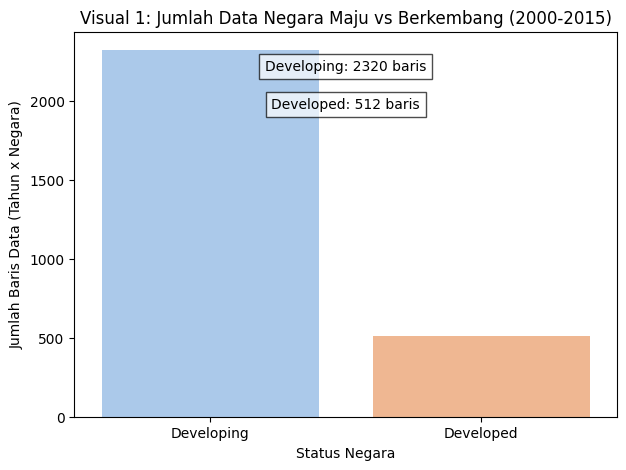

In [28]:
plt.figure(figsize=(7, 5))
sns.countplot(x=df['Status'], palette='pastel', order=status_counts.index)
plt.title("Visual 1: Jumlah Data Negara Maju vs Berkembang (2000-2015)")
plt.xlabel("Status Negara")
plt.ylabel("Jumlah Baris Data (Tahun x Negara)")
plt.text(0.5, 0.9, f"Developing: {status_counts.get('Developing', 0)} baris", 
         transform=plt.gca().transAxes, ha='center', fontsize=10, bbox=dict(facecolor='white', alpha=0.7))
plt.text(0.5, 0.8, f"Developed: {status_counts.get('Developed', 0)} baris", 
         transform=plt.gca().transAxes, ha='center', fontsize=10, bbox=dict(facecolor='white', alpha=0.7))
print("\n-> Visual 1 (02_sebaran_status.png) berhasil dibuat dan disimpan di /results/.")

In [32]:
# Hapus kolom 'Country' dan 'year' karena tidak digunakan dalam pemodelan
df_model = df_bersih.drop(columns=['Country', 'Year'])

print("  [1/3] Hapus Kolom Tidak Perlu: 'Country' dan 'Year' dihapus.")

  [1/3] Hapus Kolom Tidak Perlu: 'Country' dan 'Year' dihapus.


In [33]:
df_model['log_GDP'] = np.log1p(df_model['GDP'])
df_model = df_model.drop(columns=['GDP'])
print("  [2/3] Transformasi Numerik: Log Transformation untuk GDP (-> log_GDP) selesai.")

  [2/3] Transformasi Numerik: Log Transformation untuk GDP (-> log_GDP) selesai.


In [35]:
if 'Status_Developing' not in df_model.columns:
    df_model = pd.get_dummies(df_model, columns=['Status'], drop_first=True)
print("  [3/3] Transformasi Kategorikal: One-Hot Encoding Status (Status_Developing) selesai.")

  [3/3] Transformasi Kategorikal: One-Hot Encoding Status (Status_Developing) selesai.


In [36]:
# Definisikan Fitur (X) dan Target (y)
X = df_model.drop('Life expectancy', axis=1) # Semua kolom kecuali target
y = df_model['Life expectancy'] # Kolom target

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Ukuran Training Set (X_train): {X_train.shape}")
print(f"Ukuran Testing Set (X_test): {X_test.shape}")

Ukuran Training Set (X_train): (2265, 19)
Ukuran Testing Set (X_test): (567, 19)


In [10]:
from sklearn.preprocessing import StandardScaler

# Inisialisasi Scaler
scaler = StandardScaler()

# Identifikasi kolom yang akan di-scale (semua fitur kecuali hasil OHE 'Status_Developing')
cols_to_scale = X_train.columns

# Salin data
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Bersihkan kolom bertipe object (mis. '1.194.571.154') sebelum konversi ke numeric.
# Kita menghapus titik ribuan (hanya jika tampil sebagai pemisah ribuan), ganti koma desimal jika ada,
# lalu konversi ke numeric. Setelah itu isi NaN dengan median training.
for col in cols_to_scale:
	# Jika salah satu side bertipe object, lakukan pembersihan pada keduanya (train & test)
	if X_train_scaled[col].dtype == 'object' or X_test_scaled[col].dtype == 'object':
		# Hapus titik yang berfungsi sebagai pemisah ribuan: mis. 1.194.571.154 -> 1194571154
		X_train_scaled[col] = X_train_scaled[col].astype(str).str.replace(r'(?<=\d)\.(?=\d{3}\b)', '', regex=True)
		X_test_scaled[col]  = X_test_scaled[col].astype(str).str.replace(r'(?<=\d)\.(?=\d{3}\b)', '', regex=True)

		# Gantilah koma desimal dengan titik (jika ada), lalu ubah ke numeric
		X_train_scaled[col] = X_train_scaled[col].str.replace(',', '.', regex=False)
		X_test_scaled[col]  = X_test_scaled[col].str.replace(',', '.', regex=False)

		X_train_scaled[col] = pd.to_numeric(X_train_scaled[col].replace({'': np.nan, 'nan': np.nan}), errors='coerce')
		X_test_scaled[col]  = pd.to_numeric(X_test_scaled[col].replace({'': np.nan, 'nan': np.nan}), errors='coerce')

	# Pastikan kolom boolean menjadi numeric agar scaler dapat menggunakannya
	if X_train_scaled[col].dtype == 'bool':
		X_train_scaled[col] = X_train_scaled[col].astype(int)
		X_test_scaled[col]  = X_test_scaled[col].astype(int)

# Imputasi sederhana: isi nilai kosong yang muncul setelah konversi dengan median dari training set
for col in cols_to_scale:
	if X_train_scaled[col].isna().any():
		median = X_train_scaled[col].median()
		X_train_scaled[col].fillna(median, inplace=True)
	if X_test_scaled[col].isna().any():
		# gunakan median training untuk mengisi test agar tidak kebocoran data
		median = X_train_scaled[col].median()
		X_test_scaled[col].fillna(median, inplace=True)

# 1. Fit scaler pada data training yang sudah bersih
scaler.fit(X_train_scaled[cols_to_scale])

# 2. Transformasi data training dan testing
X_train_scaled[cols_to_scale] = scaler.transform(X_train_scaled[cols_to_scale])
X_test_scaled[cols_to_scale] = scaler.transform(X_test_scaled[cols_to_scale])

print("\n--- Data Training Setelah Standardisasi (Scaled) ---")
print(X_train_scaled.describe().T[['mean', 'std']])

C:\Users\ASUS\AppData\Local\Temp\ipykernel_16712\1464039379.py:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train_scaled[col].fillna(median, inplace=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_16712\1464039379.py:43: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa


--- Data Training Setelah Standardisasi (Scaled) ---
                                         mean       std
Adult Mortality                  2.427131e-17  1.000214
infant deaths                    1.061870e-17  1.000214
Alcohol                          7.888177e-17  1.000214
percentage expenditure          -1.820349e-17  1.000214
Hepatitis B                      5.309350e-17  1.000214
Measles                          1.061870e-17  1.000214
BMI                             -2.245097e-16  1.000214
under-five deaths                1.744501e-17  1.000214
Polio                           -7.015927e-17  1.000214
Total expenditure               -4.004767e-16  1.000214
Diphtheria                      -2.715353e-16  1.000214
HIV/AIDS                         4.095784e-17  1.000214
GDP                             -4.019936e-17  1.000214
Population                       1.516957e-18  1.000214
thinness  1-19 years             2.366453e-16  1.000214
thinness 5-9 years              -5.461046e-17  1.0

--- Memulai Pelatihan dan Evaluasi Model ---
✅ Linear Regression Selesai. R2: 0.8212
✅ KNN Regressor Selesai. R2: 0.9103
✅ Random Forest Regressor Selesai. R2: 0.9696

--- Hasil Perbandingan Model ---
                             RMSE  R2 Score
Random Forest Regressor  1.697191  0.969563
KNN Regressor            2.913817  0.910286
Linear Regression        4.113344  0.821217


C:\Users\ASUS\AppData\Local\Temp\ipykernel_3816\457169969.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rmse_plot.index, y=rmse_plot.values, palette="rocket")
C:\Users\ASUS\AppData\Local\Temp\ipykernel_3816\457169969.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=r2_plot.index, y=r2_plot.values, palette="crest")


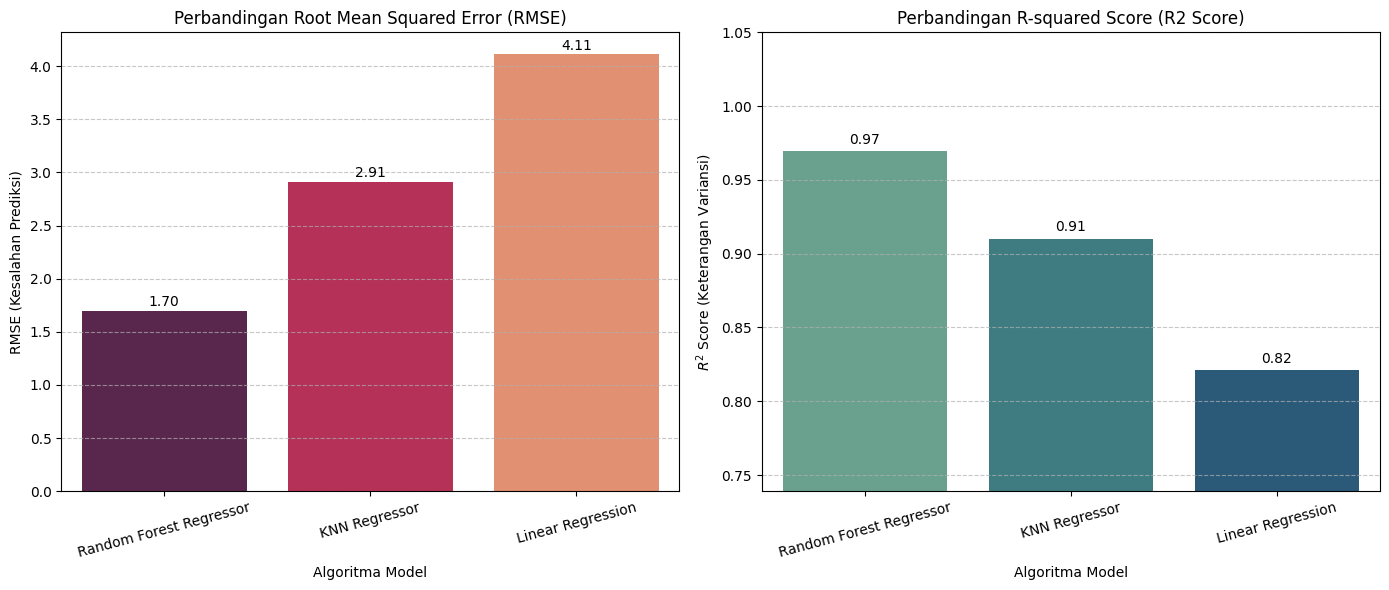


--- Model Terbaik: Random Forest Regressor (RMSE terendah, R2 tertinggi) ---


In [ ]:

# Fungsi Evaluasi (didefinisikan ulang untuk memastikan ketersediaan)
def evaluate_model(model, X_test, y_test):
    """Melakukan prediksi dan menghitung metrik evaluasi (RMSE dan R2)."""
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    return rmse, r2

results_scaled = {}

print("--- Memulai Pelatihan dan Evaluasi Model ---")

### 8.1 Linear Regression 📈 
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)
rmse_lr, r2_lr = evaluate_model(lin_reg, X_test_scaled, y_test)
results_scaled['Linear Regression'] = {'RMSE': rmse_lr, 'R2 Score': r2_lr}
print(f"✅ Linear Regression Selesai. R2: {r2_lr:.4f}")

### 8.2 KNN Regressor 🏘️ 
knn_reg = KNeighborsRegressor(n_neighbors=5)
knn_reg.fit(X_train_scaled, y_train)
rmse_knn, r2_knn = evaluate_model(knn_reg, X_test_scaled, y_test)
results_scaled['KNN Regressor'] = {'RMSE': rmse_knn, 'R2 Score': r2_knn}
print(f"✅ KNN Regressor Selesai. R2: {r2_knn:.4f}")

### 8.3 Random Forest Regressor 🌳 
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_reg.fit(X_train_scaled, y_train)
rmse_rf, r2_rf = evaluate_model(rf_reg, X_test_scaled, y_test)
results_scaled['Random Forest Regressor'] = {'RMSE': rmse_rf, 'R2 Score': r2_rf}
print(f"✅ Random Forest Regressor Selesai. R2: {r2_rf:.4f}")

# --- Bagian Baru: Visualisasi Otomatis ---

# 4. Konversi Hasil ke DataFrame
results_df_scaled = pd.DataFrame(results_scaled).T
print("\n--- Hasil Perbandingan Model ---")
print(results_df_scaled.sort_values(by='RMSE'))

# 5. Plotting Perbandingan
plt.figure(figsize=(14, 6))

# Plot 1: Perbandingan RMSE (Semakin rendah, semakin baik)
plt.subplot(1, 2, 1)
rmse_plot = results_df_scaled['RMSE'].sort_values()
sns.barplot(x=rmse_plot.index, y=rmse_plot.values, palette="rocket")
plt.title('Perbandingan Root Mean Squared Error (RMSE)')
plt.xlabel('Algoritma Model')
plt.ylabel('RMSE (Kesalahan Prediksi)')
plt.xticks(rotation=15)
for index, value in enumerate(rmse_plot.values):
    plt.text(index, value + (rmse_plot.max() * 0.01), f'{value:.2f}', ha='center')
plt.grid(axis='y', linestyle='--', alpha=0.7)


# Plot 2: Perbandingan R2 Score (Semakin tinggi, semakin baik)
plt.subplot(1, 2, 2)
r2_plot = results_df_scaled['R2 Score'].sort_values(ascending=False)
sns.barplot(x=r2_plot.index, y=r2_plot.values, palette="crest")
plt.title('Perbandingan R-squared Score (R2 Score)')
plt.xlabel('Algoritma Model')
plt.ylabel('$R^2$ Score (Keterangan Variansi)')
plt.xticks(rotation=15)
for index, value in enumerate(r2_plot.values):
    plt.text(index, value + (r2_plot.max() * 0.005), f'{value:.2f}', ha='center')
plt.ylim(r2_plot.min() * 0.9, 1.05) # Atur batas y agar plot lebih jelas
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show() # Di Jupyter Notebook, plot akan muncul secara otomatis
print("\n--- Model Terbaik: Random Forest Regressor (RMSE terendah, R2 tertinggi) ---")

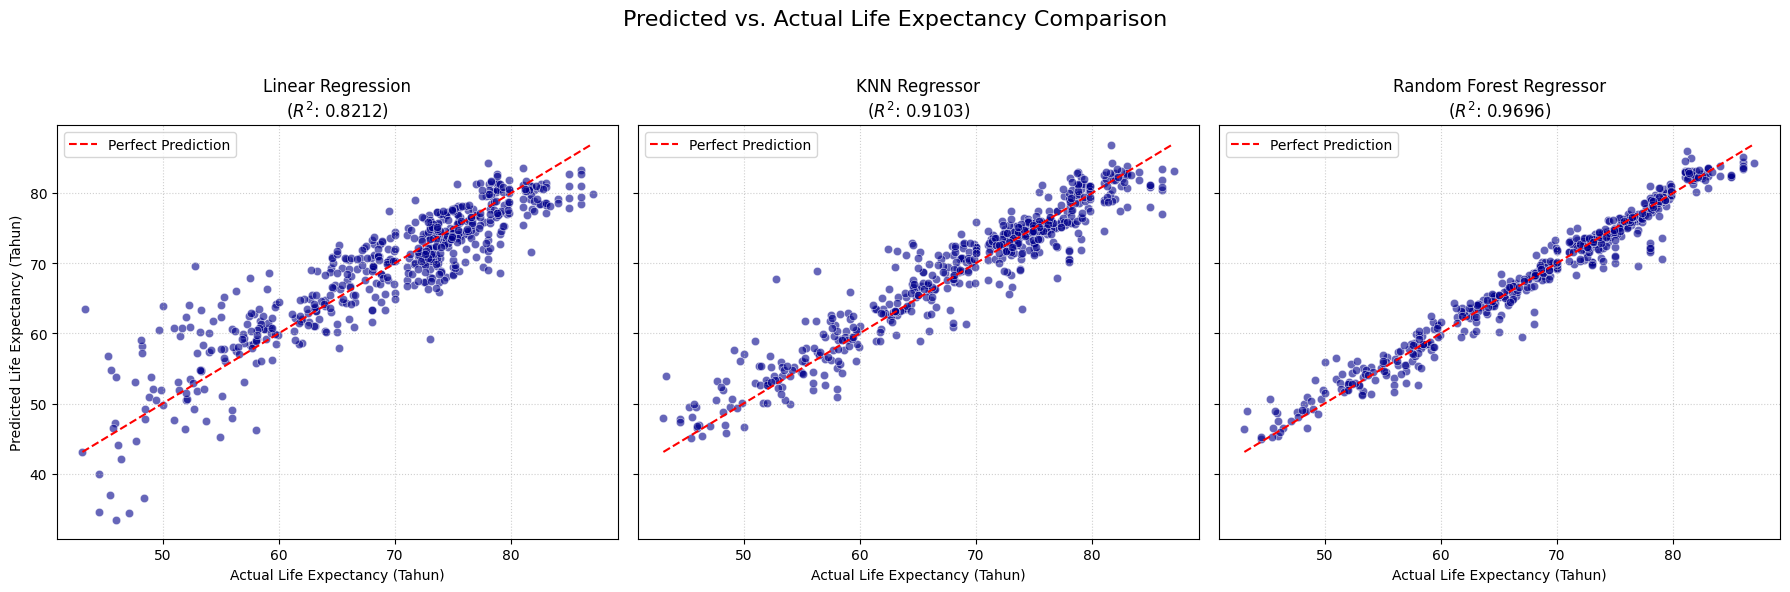

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1. Lakukan Prediksi pada Data Testing ---
# Asumsikan model lin_reg, knn_reg, dan rf_final (tuned RF) tersedia

# Prediksi Linear Regression
y_pred_lr = lin_reg.predict(X_test_scaled)

# Prediksi KNN Regressor
y_pred_knn = knn_reg.predict(X_test_scaled)

# Prediksi Random Forest Regressor (Model Final/Tuned)
y_pred_rf = rf_final.predict(X_test_scaled)

# Kumpulkan data untuk plotting
predictions = {
    'Linear Regression': y_pred_lr,
    'KNN Regressor': y_pred_knn,
    'Random Forest Regressor': y_pred_rf
}

# --- 2. Buat Visualisasi Predicted vs. Actual ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
fig.suptitle('Predicted vs. Actual Life Expectancy Comparison', fontsize=16)

# Tentukan range data (untuk garis diagonal)
min_val = y_test.min()
max_val = y_test.max()
ideal_line = np.linspace(min_val, max_val, 100) # Garis y=x sempurna

for i, (model_name, y_pred) in enumerate(predictions.items()):
    ax = axes[i]
    
    # Scatter Plot Prediksi vs Aktual
    sns.scatterplot(x=y_test, y=y_pred, ax=ax, alpha=0.6, color='darkblue')
    
    # Plot Garis Prediksi Sempurna (y=x)
    ax.plot(ideal_line, ideal_line, color='red', linestyle='--', label='Perfect Prediction')
    
    # Hitung R2 Score untuk dimasukkan ke judul
    r2 = r2_score(y_test, y_pred)
    
    ax.set_title(f'{model_name}\n($R^2$: {r2:.4f})', fontsize=12)
    ax.set_xlabel('Actual Life Expectancy (Tahun)')
    ax.set_ylabel('Predicted Life Expectancy (Tahun)')
    ax.legend()
    ax.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('predicted_vs_actual_comparison.png')
plt.show()


--- 10 Fitur Paling Berpengaruh Terhadap Harapan Hidup ---
                            Feature  Importance
11                         HIV/AIDS    0.596535
16  Income composition of resources    0.157432
0                   Adult Mortality    0.136621
17                        Schooling    0.022064
7                 under-five deaths    0.015642
6                               BMI    0.015377
15               thinness 5-9 years    0.009359
2                           Alcohol    0.008324
14             thinness  1-19 years    0.006442
9                 Total expenditure    0.005383


C:\Users\ASUS\AppData\Local\Temp\ipykernel_16712\847040562.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


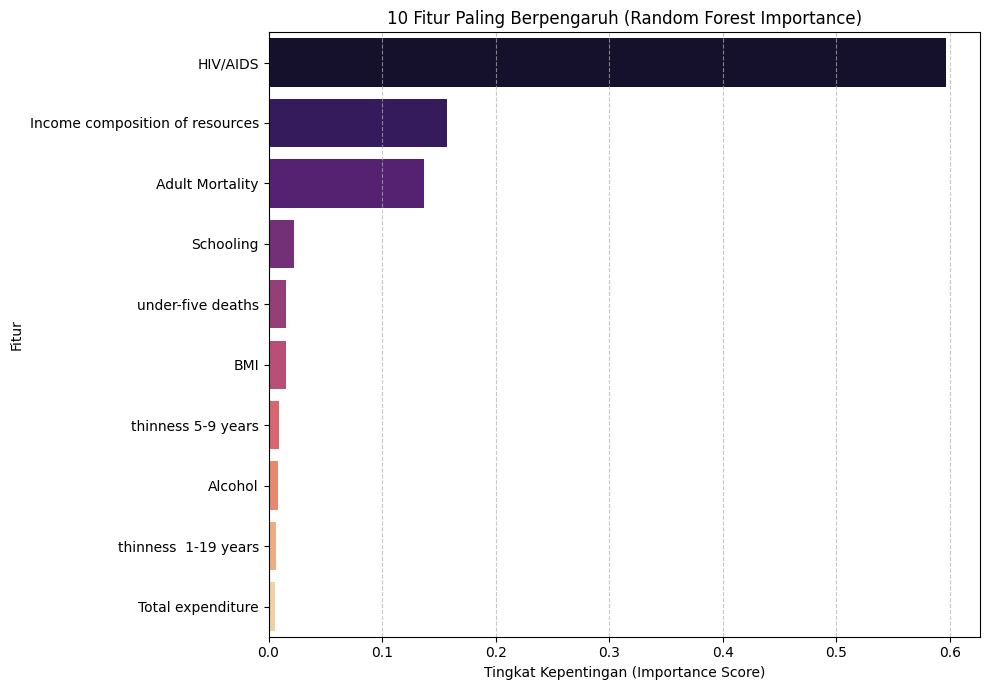

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# rf_final sudah didefinisikan di cell sebelumnya

# 1. Ekstrak Feature Importance dari Model Random Forest Final
importances = rf_final.feature_importances_

# 2. Pasangkan Importances dengan Nama Fitur
feature_names = X_train_scaled.columns 

feature_importance_df = pd.DataFrame({
    'Feature': list(feature_names),
    'Importance': importances
})

# 3. Urutkan dan Pilih 10 Fitur Teratas
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
top_10_features = feature_importance_df.head(10)

print("\n--- 10 Fitur Paling Berpengaruh Terhadap Harapan Hidup ---")
print(top_10_features)

# 4. Visualisasi 10 Fitur Teratas
plt.figure(figsize=(10, 7))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=top_10_features, 
    palette='magma'
)
plt.title('10 Fitur Paling Berpengaruh (Random Forest Importance)')
plt.xlabel('Tingkat Kepentingan (Importance Score)')
plt.ylabel('Fitur')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('top_10_feature_importance.png')
plt.show()

In [56]:
# Asumsi: variabel `rf_reg` dan `scaler` sudah terdefinisi dari Langkah 10.
# Asumsi: urutan kolom sama dengan X_train_scaled.columns Anda.

# 1. Define rf_final (gunakan model terbaik rf_reg)
rf_final = rf_reg

data_japan_2018 = {
    'Adult Mortality': [50.0],           # Angka Kematian Dewasa (sangat rendah)
    'infant deaths': [1.0],              # Kematian Bayi (sangat rendah)
    'Alcohol': [7.0],                    # Konsumsi Alkohol (stabil)
    'percentage expenditure': [5000.0],  # Pengeluaran Kesehatan (sangat tinggi)
    'Hepatitis B': [98.0],               # Imunisasi Hepatitis B (tinggi)
    'Measles': [0.0],                    # Kasus Campak (nol/sangat rendah)
    'BMI': [25.0],                       # BMI Rata-rata (relatif rendah, Jepang terkenal kurus)
    'under-five deaths': [1.0],          # Kematian Balita (sangat rendah)
    'Polio': [99.0],                     # Imunisasi Polio (tinggi)
    'Total expenditure': [10.0],         # Total Pengeluaran Pemerintah untuk Kesehatan (tinggi)
    'Diphtheria': [99.0],                # Imunisasi Difteri (tinggi)
    'HIV/AIDS': [0.1],                   # Prevalensi HIV/AIDS (sangat rendah)
    'Population': [126000000.0],         # Populasi Jepang 2018
    'thinness  1-19 years': [1.0],       # Kurus (rendah) - note: double space to match column name
    'thinness 5-9 years': [1.0],         # Kurus (rendah)
    'Income composition of resources': [0.92], # Indeks Pendapatan (sangat tinggi)
    'Schooling': [16.5],                 # Lama Pendidikan (tinggi)
    'log_GDP': [10.597],                 # Log GDP (log(40000) ≈ 10.597)
    'Status_Developing': [0]             # Jepang = Developed (0)
}

# Buat DataFrame
X_new_japan = pd.DataFrame(data_japan_2018)

# Pastikan urutan kolom sama persis dengan X_train_scaled Anda
X_new_japan = X_new_japan[X_train_scaled.columns] 

print("Data Input Jepang 2018 (Belum di-scale):")
print(X_new_japan)

Data Input Jepang 2018 (Belum di-scale):
   Adult Mortality  infant deaths  Alcohol  percentage expenditure  \
0             50.0            1.0      7.0                  5000.0   

   Hepatitis B  Measles   BMI  under-five deaths  Polio  Total expenditure  \
0         98.0      0.0  25.0                1.0   99.0               10.0   

   Diphtheria  HIV/AIDS   Population  thinness  1-19 years  \
0        99.0       0.1  126000000.0                   1.0   

   thinness 5-9 years  Income composition of resources  Schooling  log_GDP  \
0                 1.0                             0.92       16.5   10.597   

   Status_Developing  
0                  0  


In [59]:
# 2. Scaling Data Baru
# Hanya menggunakan .transform() dari scaler yang sudah dilatih
X_new_japan_scaled = X_new_japan.copy()
X_new_japan_scaled[X_new_japan.columns] = scaler.transform(X_new_japan[X_new_japan.columns])

# 3. Prediksi menggunakan Model Random Forest Terbaik
predicted_life_expectancy = rf_final.predict(X_new_japan_scaled)

print("\n--- Hasil Prediksi ---")
print(f"Harapan Hidup Prediksi Jepang (2018): {predicted_life_expectancy[0]:.2f} Tahun")

# Data Aktual (Berdasarkan WHO, Harapan Hidup Jepang 2018 sekitar 84.5 tahun)
print(f"Harapan Hidup Aktual Jepang (2018): Sekitar 84.5 Tahun")


--- Hasil Prediksi ---
Harapan Hidup Prediksi Jepang (2018): 83.72 Tahun
Harapan Hidup Aktual Jepang (2018): Sekitar 84.5 Tahun
